In [1]:
#Pemanggilan Library
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Dense, Activation,Dropout,Conv2D, MaxPooling2D,BatchNormalization, Flatten,Input
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras import regularizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model, load_model, Sequential
from tensorflow.keras.callbacks import ModelCheckpoint
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import os
import seaborn as sns
sns.set_style('darkgrid')
from sklearn.metrics import confusion_matrix, classification_report
from IPython.display import display, HTML

In [2]:
# Menentukan direktori utama yang berisi dataset
sdir=r'C:/Irsyad Fadillah/Semester 5/ASIK23/makrozoobenthos/'

# Inisialisasi list untuk menyimpan path file dan label
filepaths=[]
labels=[]

# Mengambil daftar kelas (sub-direktori) dalam direktori utama
classlist=os.listdir(sdir)

# Iterasi melalui setiap kelas
for klass in classlist:
    # Membentuk path lengkap untuk setiap kelas
    classpath=os.path.join(sdir,klass)
     # Memastikan bahwa yang diiterasi adalah direktori (bukan file)
    if os.path.isdir(classpath):
        # Mengambil daftar file dalam setiap kelas
        flist=os.listdir(classpath)
        # Iterasi melalui setiap file dalam kelas
        for f in flist:
            # Membentuk path lengkap untuk setiap file
            fpath=os.path.join(classpath,f)
             # Menyimpan path file dan label ke dalam list
            filepaths.append(fpath)
            labels.append(klass)      
# Membuat Pandas Series untuk path file dan label            
Fseries= pd.Series(filepaths, name='filepaths')
Lseries=pd.Series(labels, name='labels')    

# Menggabungkan kedua Series menjadi DataFrame
df=pd.concat([Fseries, Lseries], axis=1)
# Menampilkan lima baris pertama dari DataFrame
print (df.head())
# Menampilkan jumlah sampel untuk setiap kelas
print (df['labels'].value_counts())

                                           filepaths labels
0  C:/Irsyad Fadillah/Semester 5/ASIK23/makrozoob...  Clams
1  C:/Irsyad Fadillah/Semester 5/ASIK23/makrozoob...  Clams
2  C:/Irsyad Fadillah/Semester 5/ASIK23/makrozoob...  Clams
3  C:/Irsyad Fadillah/Semester 5/ASIK23/makrozoob...  Clams
4  C:/Irsyad Fadillah/Semester 5/ASIK23/makrozoob...  Clams
labels
Jelly_Fish     845
Sea_Urchins    579
Octopus        562
Nudibranchs    500
Crabs          499
Lobster        499
Starfish       499
Clams          497
Shrimp         488
Squid          483
Name: count, dtype: int64


In [3]:
from sklearn.model_selection import train_test_split

# Proporsi pembagian data
train_split = 0.8
test_split = 0.2  
dummy_split = 0.5  

# Memisahkan dataset menjadi set pelatihan dan set dummy (penggantian nama)
train_df, dummy_df = train_test_split(df, train_size=train_split, shuffle=True, random_state=123)
# Memisahkan set dummy menjadi set pengujian dan set validasi
test_df, valid_df = train_test_split(dummy_df, test_size=dummy_split, shuffle=True, random_state=123)
# Menampilkan panjang setiap dataset
print('train_df length:', len(train_df), '  test_df length:', len(test_df), '  valid_df length:', len(valid_df))

train_df length: 4360   test_df length: 545   valid_df length: 546


In [4]:
#pengaturan generator gambar untuk digunakan selama pelatihan, validasi, dan pengujian model menggunakan TensorFlow dan Keras
# Pengaturan parameter
height=224
width=224
channels=3
batch_size=64

# Membentuk tuple yang menyimpan dimensi gambar
img_shape=(height, width, channels)
img_size=(height, width)
length=len(test_df)

# Menampilkan informasi tentang batch size dan steps untuk dataset pengujian
test_batch_size=sorted([int(length/n) for n in range(1,length+1) if length % n ==0 and length/n<=80],reverse=True)[0]  
test_steps=int(length/test_batch_size)
print ( 'test batch size: ' ,test_batch_size, '  test steps: ', test_steps)

# Membuat objek ImageDataGenerator untuk augmentasi dan preprocessing
gen=ImageDataGenerator(
    rescale=1./255,
    )
# Membuat generator untuk dataset pelatihan
train_gen=gen.flow_from_dataframe( train_df, x_col='filepaths', y_col='labels', target_size=img_size, class_mode='categorical',
                                    color_mode='rgb', shuffle=True, batch_size=batch_size)
# Membuat generator untuk dataset validasi
validgen=ImageDataGenerator(rescale=1./255)
valid_gen=validgen.flow_from_dataframe( valid_df, x_col='filepaths', y_col='labels', target_size=img_size, class_mode='categorical',
                                    color_mode='rgb', shuffle=True, batch_size=batch_size)
# Membuat generator untuk dataset pengujian
testgen=ImageDataGenerator(rescale=1./255)
test_gen=testgen.flow_from_dataframe( test_df, x_col='filepaths', y_col='labels', target_size=img_size, class_mode='categorical',
                                    color_mode='rgb', shuffle=False, batch_size=test_batch_size)
# Mendapatkan daftar kelas (labels) dari generator pelatihan
classes=list(train_gen.class_indices.keys())
print (classes)
# Menghitung jumlah kelas
class_count=len(classes)

test batch size:  5   test steps:  109
Found 4360 validated image filenames belonging to 10 classes.
Found 546 validated image filenames belonging to 10 classes.
Found 545 validated image filenames belonging to 10 classes.
['Clams', 'Crabs', 'Jelly_Fish', 'Lobster', 'Nudibranchs', 'Octopus', 'Sea_Urchins', 'Shrimp', 'Squid', 'Starfish']


In [5]:
#menampilkan sampel gambar dari generator
def show_image_samples(gen):
    test_dict=test_gen.class_indices
    classes=list(test_dict.keys())    
    images,labels=next(gen)  
    plt.figure(figsize=(20, 20))
        # Menentukan jumlah gambar yang akan ditampilkan (maksimum 25)
    length=len(labels)
    if length<25:   
        r=length
    else:
        r=25
    for i in range(r):
        plt.subplot(5, 5, i + 1)
        image=images[i]
        plt.imshow(image)
        index=np.argmax(labels[i])
        class_name=classes[index]
        plt.title(class_name, color='blue', fontsize=16)
        plt.axis('off')
    plt.show()

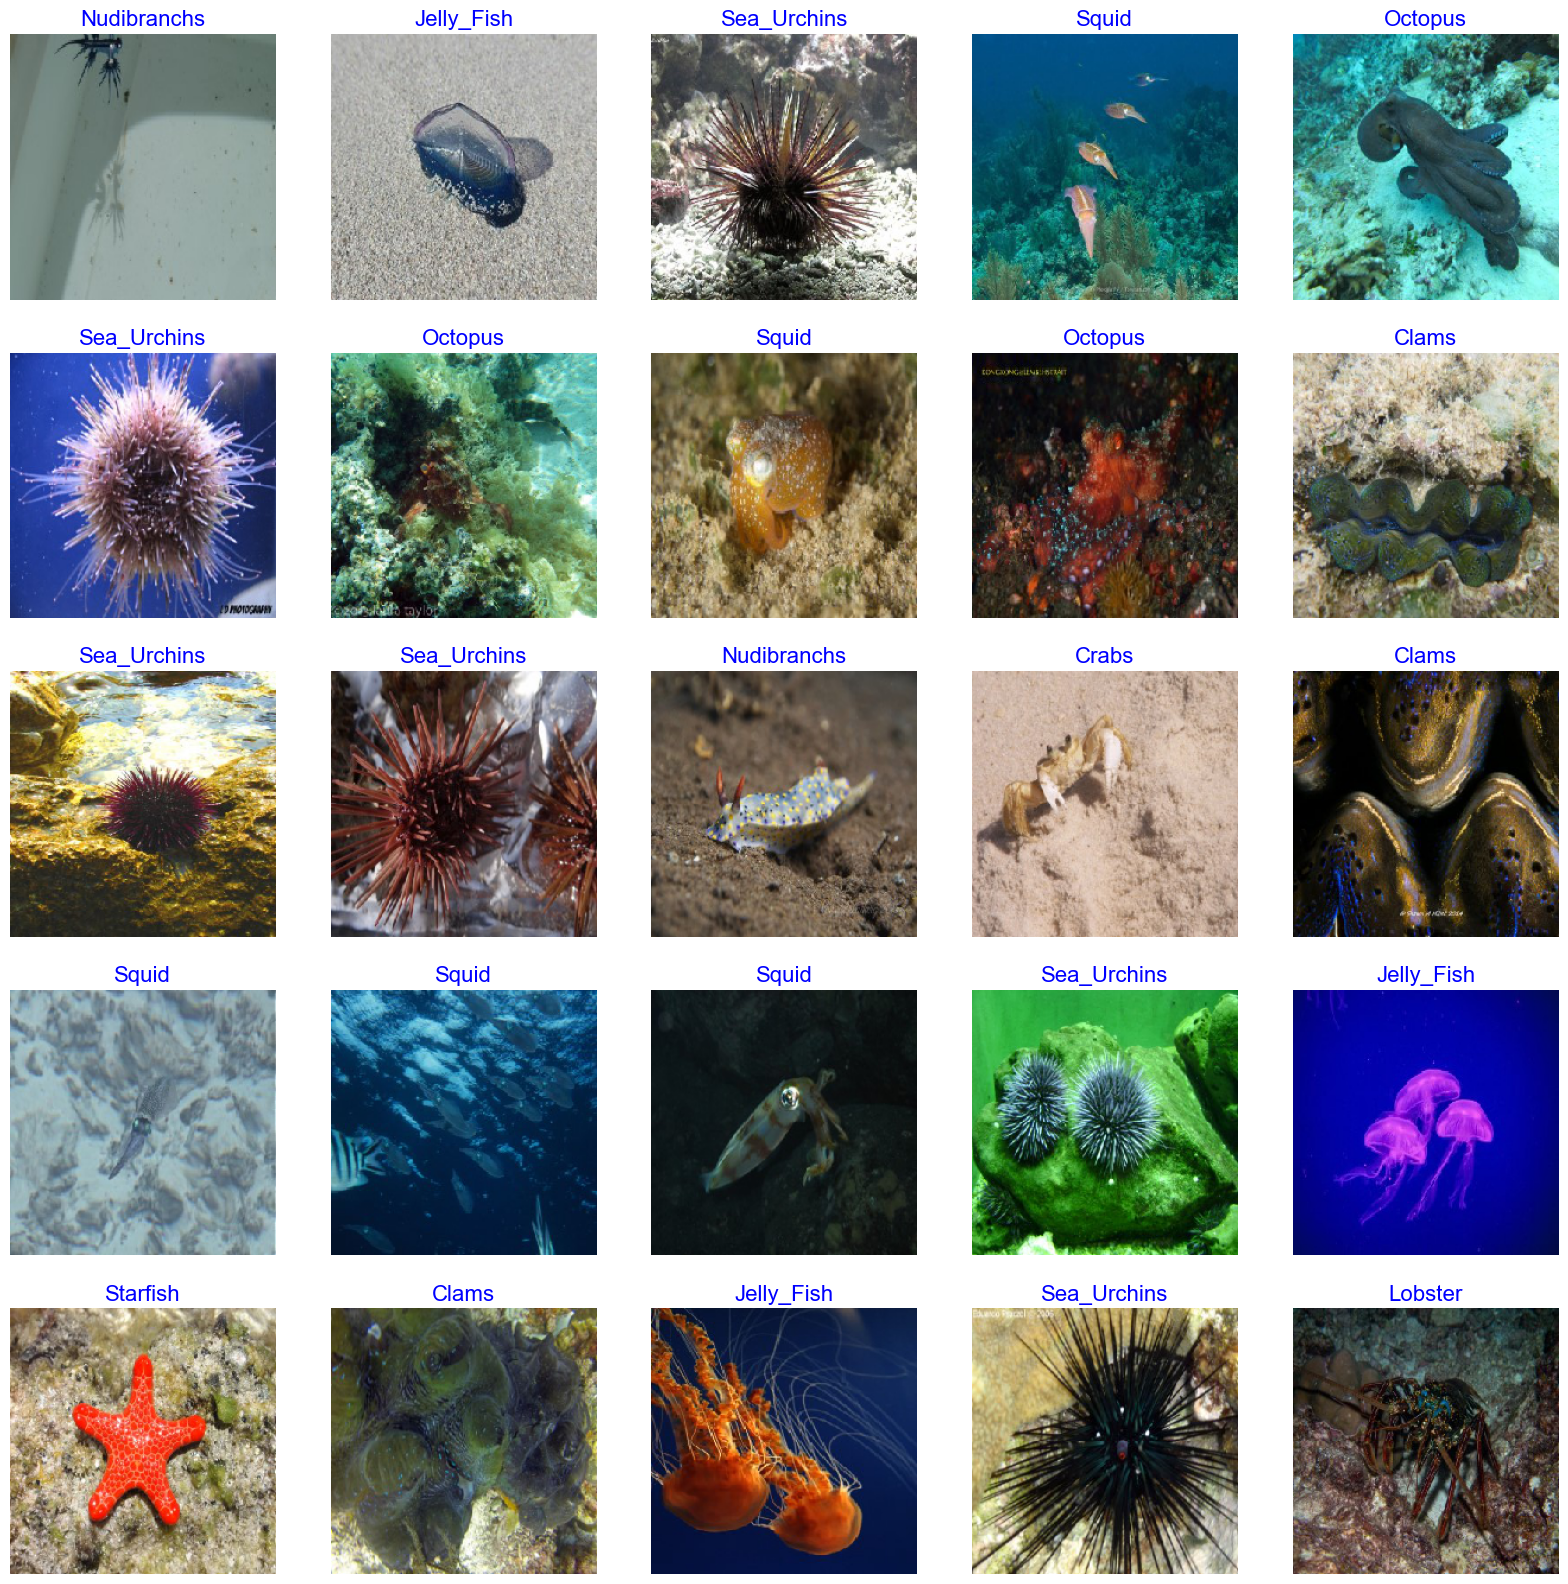

In [6]:
show_image_samples(train_gen)

In [7]:
#penggunaan model Xception sebagai model dasar (base model)
base_model=tf.keras.applications.Xception(include_top=False, weights="imagenet",input_tensor=Input(shape=(224,224,3))) 

In [8]:
base_model.summary()

Model: "xception"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 block1_conv1 (Conv2D)       (None, 111, 111, 32)         864       ['input_1[0][0]']             
                                                                                                  
 block1_conv1_bn (BatchNorm  (None, 111, 111, 32)         128       ['block1_conv1[0][0]']        
 alization)                                                                                       
                                                                                                  
 block1_conv1_act (Activati  (None, 111, 111, 32)         0         ['block1_conv1_bn[0][0]

In [9]:
#freeze
base_model.trainable = False

In [10]:
#membuat model baru menggunakan Sequential API dari TensorFlow dan Keras
model_name='Asik23'
print("Building model with", base_model)
model = tf.keras.Sequential([
            # Note the input shape is the desired size of the image 128x128 with 3 bytes color
            # This is the first convolution
            base_model,
            tf.keras.layers.Conv2D(filters=32, padding='same', kernel_size=3, activation='relu', strides=1),
            tf.keras.layers.MaxPool2D(pool_size=2, strides=2),
            tf.keras.layers.Dropout(rate=0.5),

            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(10, activation='softmax')
])

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=.001), loss='categorical_crossentropy', metrics='accuracy')

Building model with <keras.src.engine.functional.Functional object at 0x000001D6B1AF4FD0>


In [11]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception (Functional)       (None, 7, 7, 2048)        20861480  
                                                                 
 conv2d_4 (Conv2D)           (None, 7, 7, 32)          589856    
                                                                 
 max_pooling2d (MaxPooling2  (None, 3, 3, 32)          0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 3, 3, 32)          0         
                                                                 
 flatten (Flatten)           (None, 288)               0         
                                                                 
 dense (Dense)               (None, 10)                2890      
                                                        

In [12]:
#melatih model menggunakan data pelatihan (train_gen) dan data validasi (valid_gen)
epochs = 20

history=model.fit(x=train_gen, epochs=epochs, validation_data=valid_gen)

Epoch 1/20


69/69 [==============================] - 294s 4s/step - loss: 1.1310 - accuracy: 0.6376 - val_loss: 0.6851 - val_accuracy: 0.7930
Epoch 2/20
69/69 [==============================] - 313s 5s/step - loss: 0.7152 - accuracy: 0.7608 - val_loss: 0.5853 - val_accuracy: 0.8077
Epoch 3/20
69/69 [==============================] - 306s 4s/step - loss: 0.6005 - accuracy: 0.8025 - val_loss: 0.5207 - val_accuracy: 0.8278
Epoch 4/20
69/69 [==============================] - 308s 4s/step - loss: 0.5007 - accuracy: 0.8321 - val_loss: 0.5068 - val_accuracy: 0.8260
Epoch 5/20
69/69 [==============================] - 299s 4s/step - loss: 0.4423 - accuracy: 0.8548 - val_loss: 0.5209 - val_accuracy: 0.8132
Epoch 6/20
69/69 [==============================] - 368s 5s/step - loss: 0.3757 - accuracy: 0.8718 - val_loss: 0.4871 - val_accuracy: 0.8480
Epoch 7/20
69/69 [==============================] - 357s 5s/step - loss: 0.3400 - accuracy: 0.8846 - val_loss: 0.5695 - val_accuracy: 0.8425
Epoch 8/20


In [13]:
def print_in_color(txt_msg,fore_tupple,back_tupple,):
    # Memisahkan komponen warna dari tupel warna depan (foreground) dan belakang (background)
    rf,gf,bf=fore_tupple
    rb,gb,bb=back_tupple
    # Membentuk string yang berisi format ANSI escape code untuk warna teks dan latar belakang
    msg='{0}' + txt_msg
    mat='\33[38;2;' + str(rf) +';' + str(gf) + ';' + str(bf) + ';48;2;' + str(rb) + ';' +str(gb) + ';' + str(bb) +'m' 
    print(msg .format(mat), flush=True)
    print('\33[0m', flush=True) # Mengembalikan warna cetakan ke warna default (hitam)
    return

In [14]:
#membuat plot dari data pelatihan dan validasi seperti loss dan akurasi selama proses pelatihan model
def tr_plot(tr_data, start_epoch):
   # Mendapatkan data pelatihan dan validasi
    tacc=tr_data.history['accuracy']
    tloss=tr_data.history['loss']
    vacc=tr_data.history['val_accuracy']
    vloss=tr_data.history['val_loss']
    
     # Menghitung jumlah epoch
    Epoch_count=len(tacc)+ start_epoch
    Epochs=[]
    for i in range (start_epoch ,Epoch_count):
        Epochs.append(i+1)  
    # Menentukan epoch dengan validation loss terendah
    index_loss=np.argmin(vloss)
    val_lowest=vloss[index_loss]
    # Menentukan epoch dengan validation accuracy tertinggi
    index_acc=np.argmax(vacc)
    acc_highest=vacc[index_acc]
    plt.style.use('fivethirtyeight')
    
    sc_label='best epoch= '+ str(index_loss+1 +start_epoch)
    vc_label='best epoch= '+ str(index_acc + 1+ start_epoch)
    fig,axes=plt.subplots(nrows=1, ncols=2, figsize=(20,8))
    
    axes[0].plot(Epochs,tloss, 'r', label='Training loss')
    axes[0].plot(Epochs,vloss,'g',label='Validation loss' )
    axes[0].scatter(index_loss+1 +start_epoch,val_lowest, s=150, c= 'blue', label=sc_label)
    axes[0].set_title('Training and Validation Loss')
    axes[0].set_xlabel('Epochs')
    axes[0].set_ylabel('Loss')
    axes[0].legend()
    axes[1].plot (Epochs,tacc,'r',label= 'Training Accuracy')
    axes[1].plot (Epochs,vacc,'g',label= 'Validation Accuracy')
    axes[1].scatter(index_acc+1 +start_epoch,acc_highest, s=150, c= 'blue', label=vc_label)
    axes[1].set_title('Training and Validation Accuracy')
    axes[1].set_xlabel('Epochs')
    axes[1].set_ylabel('Accuracy')
    axes[1].legend()
    plt.tight_layout
    plt.show()

In [15]:
def print_info( test_gen, preds, print_code, save_dir, subject ): 
#mencetak informasi tentang performa model klasifikasi, termasuk informasi tentang kesalahan klasifikasi, 
#matriks kebingungan (confusion matrix), dan laporan klasifikasi
    class_dict=test_gen.class_indices
    labels= test_gen.labels
    file_names= test_gen.filenames 
    error_list=[]
    true_class=[]
    pred_class=[]
    prob_list=[]
    new_dict={}
    error_indices=[]
    y_pred=[]
    # Membuat dictionary baru yang memetakan indeks kelas ke nama kelas
    for key,value in class_dict.items():
        new_dict[value]=key   
    # Menyimpan dictionary baru sebagai teks dalam file
    classes=list(new_dict.values())     
    dict_as_text=str(new_dict)
    dict_name= subject + '-' +str(len(classes)) +'.txt'  
    dict_path=os.path.join(save_dir,dict_name)    
    with open(dict_path, 'w') as x_file:
        x_file.write(dict_as_text)    
    errors=0      
    for i, p in enumerate(preds):
        pred_index=np.argmax(p)        
        true_index=labels[i]  
        # Mengecek apakah terjadi kesalahan klasifikasi
        if pred_index != true_index: 
            error_list.append(file_names[i])
            true_class.append(new_dict[true_index])
            pred_class.append(new_dict[pred_index])
            prob_list.append(p[pred_index])
            error_indices.append(true_index)            
            errors=errors + 1
        y_pred.append(pred_index)    
    if print_code !=0:
        if errors>0:
            if print_code>errors:
                r=errors
            else:
                r=print_code           
            msg='{0:^28s}{1:^28s}{2:^28s}{3:^16s}'.format('Filename', 'Predicted Class' , 'True Class', 'Probability')
            print_in_color(msg, (0,255,0),(55,65,80))
            for i in range(r):                
                split1=os.path.split(error_list[i])                
                split2=os.path.split(split1[0])                
                fname=split2[1] + '/' + split1[1]
                msg='{0:^28s}{1:^28s}{2:^28s}{3:4s}{4:^6.4f}'.format(fname, pred_class[i],true_class[i], ' ', prob_list[i])
                print_in_color(msg, (255,255,255), (55,65,60))
                #print(error_list[i]  , pred_class[i], true_class[i], prob_list[i])               
        else:
            msg='With accuracy of 100 % there are no errors to print'
            print_in_color(msg, (0,255,0),(55,65,80))
    if errors>0:
        plot_bar=[]
        plot_class=[]
        for  key, value in new_dict.items():        
            count=error_indices.count(key) 
            if count!=0:
                plot_bar.append(count) 
                plot_class.append(value)   
        fig=plt.figure()
        fig.set_figheight(len(plot_class)/3)
        fig.set_figwidth(10)
        plt.style.use('fivethirtyeight')
        for i in range(0, len(plot_class)):
            c=plot_class[i]
            x=plot_bar[i]
            plt.barh(c, x, )
            plt.title( ' Errors by Class on Test Set')
    y_true= np.array(labels)        
    y_pred=np.array(y_pred)
    if len(classes)<= 30:
        # create a confusion matrix 
        cm = confusion_matrix(y_true, y_pred )        
        length=len(classes)
        if length<8:
            fig_width=8
            fig_height=8
        else:
            fig_width= int(length * .5)
            fig_height= int(length * .5)
        plt.figure(figsize=(fig_width, fig_height))
        sns.heatmap(cm, annot=True, vmin=0, fmt='g', cmap='Blues', cbar=False)       
        plt.xticks(np.arange(length)+.5, classes, rotation= 90)
        plt.yticks(np.arange(length)+.5, classes, rotation=0)
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        plt.title("Confusion Matrix")
        plt.show()
    clr = classification_report(y_true, y_pred, target_names=classes)
    print("Classification Report:\n----------------------\n", clr)

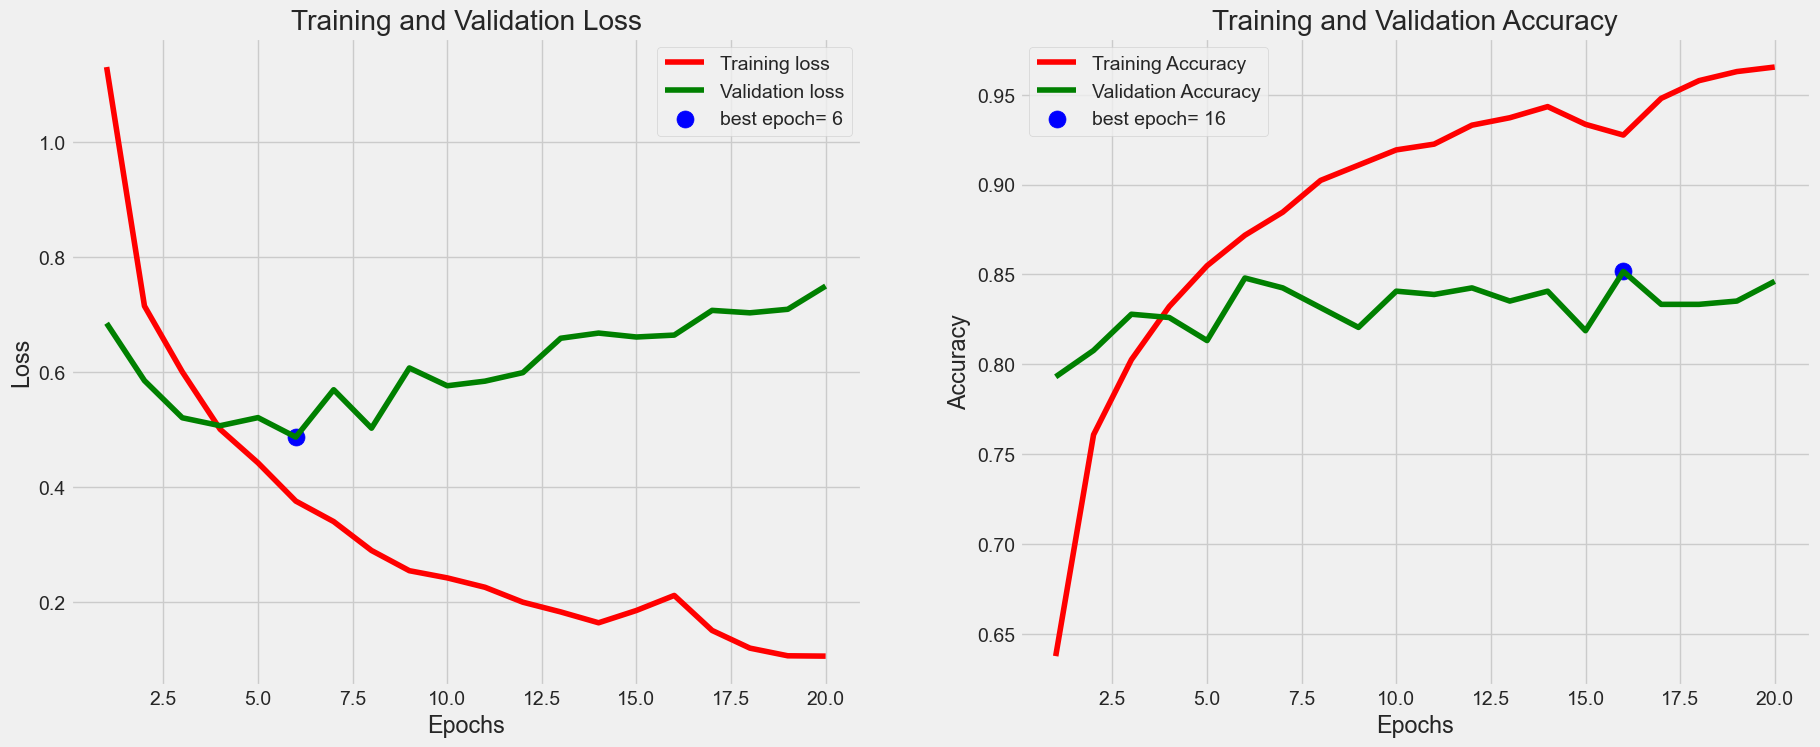

109/109 [==============================] - 36s 322ms/step - loss: 0.6526 - accuracy: 0.8349
accuracy on the test set is 83.49 %



C:\Users\asus\anaconda3\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [16]:
#menampilkan plot dari histori pelatihan (training) model, 
tr_plot(history,0)
save_dir=r'./'
subject='BenthosException101'

#mengevaluasi model pada dataset pengujian
acc=model.evaluate( test_gen, batch_size=test_batch_size, verbose=1, steps=test_steps, return_dict=False)[1]*100
msg=f'accuracy on the test set is {acc:5.2f} %'
print_in_color(msg, (0,255,0),(55,65,80))

#menyimpan model ke dalam file
save_id=str (model_name +  '-' + subject +'-'+ str(acc)[:str(acc).rfind('.')+3] + '.h5')
save_loc=os.path.join(save_dir, save_id)
model.save(save_loc)

109/109 [==============================] - 36s 319ms/step


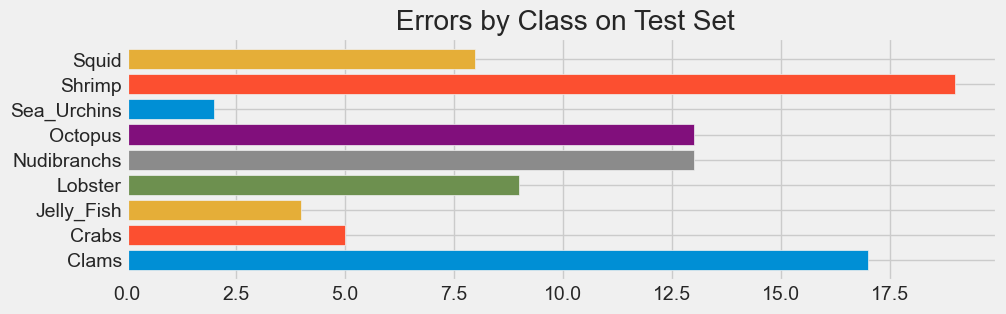

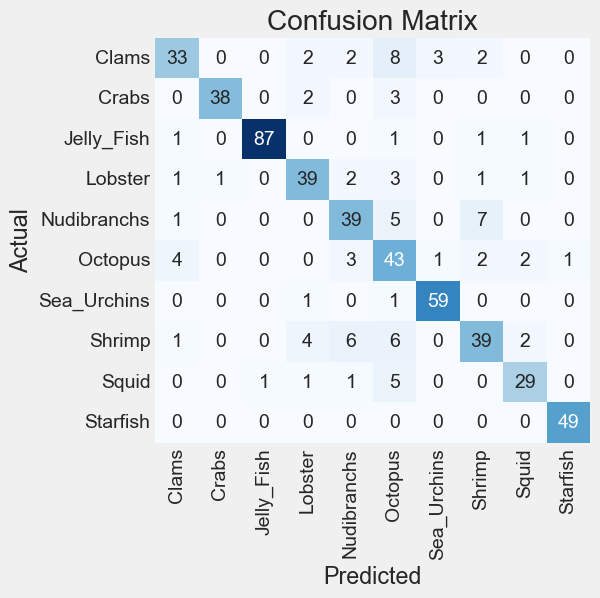

Classification Report:
----------------------
               precision    recall  f1-score   support

       Clams       0.80      0.66      0.73        50
       Crabs       0.97      0.88      0.93        43
  Jelly_Fish       0.99      0.96      0.97        91
     Lobster       0.80      0.81      0.80        48
 Nudibranchs       0.74      0.75      0.74        52
     Octopus       0.57      0.77      0.66        56
 Sea_Urchins       0.94      0.97      0.95        61
      Shrimp       0.75      0.67      0.71        58
       Squid       0.83      0.78      0.81        37
    Starfish       0.98      1.00      0.99        49

    accuracy                           0.83       545
   macro avg       0.84      0.83      0.83       545
weighted avg       0.84      0.83      0.84       545



In [17]:
print_code=0
preds=model.predict(test_gen) 
print_info( test_gen, preds, print_code, save_dir, subject )  